#### *pymdptoolbox* is a python library from which MDP examples can be imported </br>
##### Documentation of *pymdptoolbox* : https://pymdptoolbox.readthedocs.io/en/latest/api/mdptoolbox.html

In [1]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-cp36-none-any.whl size=25659 sha256=d094036fcf4c8b439ee48367d63536fa9c60506ed217b5942514b388324bd4f4
  Stored in directory: /root/.cache/pip/wheels/87/a9/a8/40c4e252c02e590737265742425cdd0365fafcc162441a9527
Successfully built pymdptoolbox


In [2]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        self.rewards2              = np.zeros((s,a))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):   
      #for reproducibility 
        np.random.seed(0)   
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards2 = np.random.rand(self.num_state,self.num_action)
        for a in self.actions:
          for s in self.states:
            for s1 in self.states:
              self.rewards[a][s][s1] = self.rewards2[s][a]
        

In [ ]:
s=3
a=2
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R

In [ ]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards =np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

In [ ]:
rho= np.ones(env.num_state)/env.num_state
V_optimal,pi_optimal=policy_iteration(env, 0.9, 0.0001)
V_rho_optimal = np.dot(rho,V_optimal)[0]

In [7]:
pi_optimal

array([[0., 1.],
       [0., 1.],
       [0., 1.]])

In [8]:
V_rho_optimal

5.522102858184402

In [ ]:
num_loops=50
iterations=1000
y = np.empty((num_loops,iterations),dtype=float)

In [10]:
for j in range(0,num_loops):
  start_time = time.time()
  Q=np.zeros((env.num_state,env.num_action))
  V=np.zeros((env.num_state,1))
  A=Q-V
  pi = np.ones((env.num_state,env.num_action)) / env.num_action

  s0=np.random.choice(env.states)
  a0=np.random.choice(env.actions,p=pi[s0])
  for i in range(0,iterations):
    alpha= 1.5/np.power(i+1,0.5)
    beta= 1.5/np.power(i+1,0.75)
    s1=np.random.choice(env.states,p=env.transitions[a0][s0][:])
    #print(pi[s0])
    a1=np.random.choice(env.actions,p=pi[s1])

    Q[s0][a0]= Q[s0][a0] + alpha * (env.rewards2[s0][a0]+(0.9 * Q[s1][a1]) - Q[s0][a0])
    V = np.reshape(np.sum(np.multiply(pi,Q),axis=1),(-1,1))
    A=Q-V
    X=np.empty((env.num_state,env.num_action),dtype=float)
    for s in env.states:
      for a in env.actions:
        X[s][a]= np.exp(beta*A[s][a])
      X[s]=X[s]/np.sum(np.multiply(X[s],pi[s]))
    #print(np.sum(X,axis=1))
    pi=np.multiply(pi,X)
    s0=s1.copy()
    a0=a1.copy()
    V_temp=evaluate_policy(env, pi, 0.9, 0.0001) 
    y[j][i]= np.dot(rho,V_temp)
  print('Iteration',j+1,'Completed')
  print("--- %s seconds ---" % (time.time() - start_time))


Iteration 1 Completed
--- 4.934814214706421 seconds ---
Iteration 2 Completed
--- 5.173887491226196 seconds ---
Iteration 3 Completed
--- 4.7549474239349365 seconds ---
Iteration 4 Completed
--- 5.094334125518799 seconds ---
Iteration 5 Completed
--- 4.573641300201416 seconds ---
Iteration 6 Completed
--- 4.948918342590332 seconds ---
Iteration 7 Completed
--- 5.316605567932129 seconds ---
Iteration 8 Completed
--- 6.005661725997925 seconds ---
Iteration 9 Completed
--- 5.049168825149536 seconds ---
Iteration 10 Completed
--- 4.681083917617798 seconds ---
Iteration 11 Completed
--- 5.224109649658203 seconds ---
Iteration 12 Completed
--- 5.379595756530762 seconds ---
Iteration 13 Completed
--- 5.0469489097595215 seconds ---
Iteration 14 Completed
--- 5.497798919677734 seconds ---
Iteration 15 Completed
--- 4.3722875118255615 seconds ---
Iteration 16 Completed
--- 4.6199095249176025 seconds ---
Iteration 17 Completed
--- 4.359055042266846 seconds ---
Iteration 18 Completed
--- 5.1301763

In [11]:
pi

array([[1.00000000e+00, 1.50421495e-21],
       [3.27476725e-35, 1.00000000e+00],
       [6.45466944e-40, 1.00000000e+00]])

In [ ]:
# Variance series 

y_var=np.empty((num_loops,iterations),dtype=float)
for i in range(0,num_loops):
  y_var[i][0]=V_rho_optimal-y[i][0]
  min_t=V_rho_optimal-y[i][0]
  for j in range(1,iterations):
    min_t=min(min_t,V_rho_optimal-y[i][j])
    y_var[i][j]=min_t.copy()
#1 log(var)
y_var_exp=np.sum(y_var,axis=0)
y_var_exp=y_var_exp/num_loops
y_var_var=np.transpose(y_var)-np.transpose(np.reshape(y_var_exp,(1,-1)))
y_var_var=y_var_var**2
y_std_dev=np.power(np.sum(np.transpose(y_var_var),axis=0)/num_loops,0.5)

#2 var(log)
#y_var_log_exp=np.sum(np.log(y_var),axis=0)
#y_var_log_exp=y_var_log_exp/1
#y_var_log=np.transpose(np.log(y_var))-np.transpose(np.reshape(y_var_log_exp,(1,-1)))
#y_var_log=y_var_log**2
#y_var_varlog=np.sum(np.transpose(y_var_log),axis=0)/1
#y_std_dev=y_var_var



In [ ]:
#expectation of V*-V(pi_t)
y_exp=np.sum(y,axis=0)
y_exp=y_exp/num_loops
y_exp=V_rho_optimal-y_exp

In [ ]:
min_list=list()
min_t=(y_exp[0])
min_list.append(min_t)
for i in range(1,len(y_exp)):
  min_t=min(min_t,y_exp[i])
  min_list.append(min_t)
#y[i]=np.array(min_list[i])[2:]+0.0001
 # y[i]=np.log(np.array(y[i],dtype=float))

In [ ]:
y_upper=np.array(min_list)+y_std_dev
y_lower=np.array(min_list)-y_std_dev
y_lower[y_lower<=0]=0.0001

log($\min_{1$\leq $t$\leq $T}$ E(V<sup>*</sup>-V<sup>$\pi$</sup><sup>t</sup>)) 

In [ ]:

def plot_log(min_list,y_upper,y_lower,y_std_dev,iterations):
    
    x=np.log(np.array(range(1,iterations+1)))/np.log(10)
    y=np.log(np.array(min_list))/np.log(10)
    slope,intercept= np.polyfit(x[5:125],y[5:125],deg=1) 
    abline_values = [slope * i + intercept for i in x]
    #x_labels=np.round(np.power(10,range(0,5)),3)
    #y_labels=np.round(np.power(10,np.arange(-0.4,0.5,0.2)),3)
    #plt.xticks(range(0,5), x_labels)
    #plt.yticks(np.arange(-0.4,0.5,0.2),y_labels)
    plt.tick_params(axis='y',labelsize=18)
    plt.tick_params(axis='x',labelsize=18)
    plt.xlabel('log (T)', fontsize=28)
    plt.ylabel('log ($\min_{1<t<T}$ E[V*-V($\pi_t$))', fontsize=28)
    plt.plot(x,y,label=' $\min_{1<t<T}$ E(V*-V($\pi_t$))',linewidth=4)
    #plt.scatter(x[:400],y[:400],label=slope,s=10,color='black')
    #plt.plot(x,y_std_dev,label='error',linewidth=2)
    label='Slope = '+ str(np.round(slope,3))
    plt.plot(x,abline_values,'r--',label=label,linewidth=2)
    #plt.plot(x,np.log(y_upper),label='upper',linewidth=2)
    #plt.plot(x,np.log(y_lower),label='lower',linewidth=2)
    #plt.plot(x,np.log(y_std_dev),label='std_dev',linewidth=2)
    
    #plt.fill_between(x,np.log(y_upper)/np.log(10),np.log(y_lower)/np.log(10),facecolor='yellow',edgecolor='yellow',alpha=0.5)
    #plt.plot(x,y_var_varlog,label='varlog')
    #plt.plot(x,y_var_logvar,label='logvar')
    fig_size=(10,9)
    plt.grid(True)
    #plt.ylim(-0.35,0.4)
    #plt.xlim(0,4)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best',title='Legend') 
    plt.show()

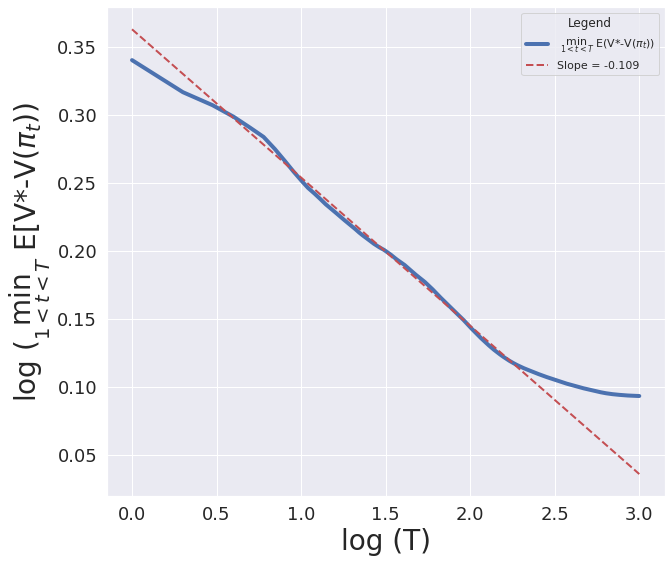

In [22]:
plot_log(min_list,y_upper,y_lower,y_std_dev,iterations)

## Find slope of best fit line  (from 0-7 on x axis)

In [ ]:
x_=np.log(np.array(range(1,iterations+1)))
y_=np.log(np.array(min_list))+0.00001

In [ ]:
slope,intercept= np.polyfit(x_[8:1808],y_[8:1808],deg=1) 

In [ ]:
slope

-0.19454972722883024

In [ ]:
intercept

0.8214074515092963

In [ ]:
np.exp(2.5)

12.182493960703473

In [ ]:
np.power(10,0.75)

5.623413251903491

In [20]:
np.power(10,2.1)

125.89254117941675

sajadkhodadadian@gmail.com